# Setup

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras import layers as L
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # stopwords
nltk.download('punkt') # Tokenizer - to use sent_tokenize, word_tokenize

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data

In [ ]:
df = pd.read_csv("/train.csv")

In [ ]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
df = df.fillna('')
df["total"] = df['title'] + " " + df["author"]
df.head()

,id,title,author,text,label,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [ ]:
X = df.drop("label", axis = 1)
Y = df["label"]

X.shape, Y.shape

((20800, 5), (20800,))

# Pre-Processing

In [ ]:
VOCAB_SIZE = 5000
text = X.copy()

In [ ]:
def text_cleaning(length):
    ps = PorterStemmer()
    corpus = []
    for i in range(length):
        m = re.sub("[^a-zA-Z]"," ",text["total"][i])
        m = m.lower()
        m = m.split()
        m = [ps.stem(word) for word in m if not word in stopwords.words('english')]
        clean_text = " ".join(m)
        corpus.append(clean_text)

    return corpus

In [ ]:
%%time
clean_text_corpus = text_cleaning(len(text))

CPU times: user 38.1 s, sys: 4.2 s, total: 42.3 s
Wall time: 42.7 s


In [ ]:
clean_text_corpus[0]

'hous dem aid even see comey letter jason chaffetz tweet darrel lucu'

In [ ]:
# to one hot
onehot_text = [one_hot(words, VOCAB_SIZE) for words in clean_text_corpus]

In [ ]:
# padding sequences
padded_doc = pad_sequences(onehot_text, padding="pre", maxlen = 25)

In [ ]:
x = np.array(padded_doc)
y = np.array(Y)

In [ ]:
# Train & Test Split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=0)

# Models

##LSTM

In [ ]:
def build_model():
    # model structure
    model = tf.keras.Sequential([
        L.Embedding(VOCAB_SIZE, 40, input_length = 25),
        L.Dropout(0.3),
        L.LSTM(100),
        L.Dropout(0.3),
        L.Dense(64, activation = "relu"),
        L.Dropout(0.3),
        L.Dense(1, activation = "sigmoid")
    ])

    model.compile(optimizer="adam", loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics = tf.metrics.BinaryAccuracy()
                 )

    return model

In [ ]:
news_classifier = build_model()
news_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

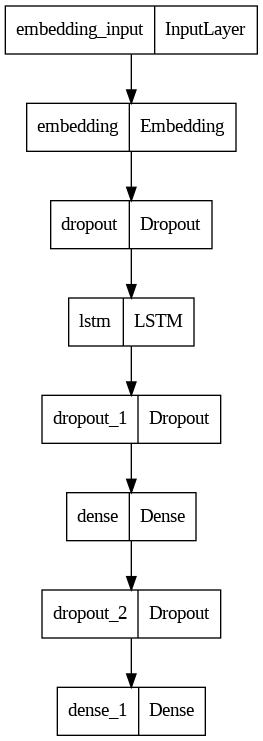

In [ ]:
tf.keras.utils.plot_model(news_classifier)

# Training

In [ ]:
my_callbacks = [tf.keras.callbacks.ModelCheckpoint("news_classifier.h5", monitor = "val_loss", save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=5),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
               ]

In [ ]:
history = news_classifier.fit(
    xtrain,
    ytrain,
    epochs = 25,
    batch_size = 128,
    validation_split = 0.2,
    callbacks = my_callbacks
)

Epoch 1/25
91/91 [==============================] - 7s 80ms/step - loss: 0.0068 - binary_accuracy: 0.9982 - val_loss: 0.0050 - val_binary_accuracy: 0.9986 - lr: 0.0010
Epoch 2/25
 3/91 [..............................] - ETA: 4s - loss: 0.0017 - binary_accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 5s 59ms/step - loss: 0.0037 - binary_accuracy: 0.9990 - val_loss: 0.0052 - val_binary_accuracy: 0.9983 - lr: 0.0010
Epoch 3/25
91/91 [==============================] - 7s 79ms/step - loss: 0.0022 - binary_accuracy: 0.9993 - val_loss: 0.0060 - val_binary_accuracy: 0.9979 - lr: 0.0010
Epoch 4/25
91/91 [==============================] - 5s 59ms/step - loss: 8.3989e-04 - binary_accuracy: 0.9999 - val_loss: 0.0078 - val_binary_accuracy: 0.9979 - lr: 0.0010
Epoch 5/25
91/91 [==============================] - 6s 71ms/step - loss: 2.0595e-04 - binary_accuracy: 1.0000 - val_loss: 0.0069 - val_binary_accuracy: 0.9979 - lr: 0.0010
Epoch 6/25
91/91 [==============================] - 6s 67ms/step - loss: 8.3622e-04 - binary_accuracy: 0.9997 - val_loss: 0.0064 - val_binary_accuracy: 0.9979 - lr: 0.0010


# Prediction

In [ ]:
predictions = news_classifier.predict(xtest)
predictions = [int(np.round(pred[0])) for pred in predictions]

195/195 [==============================] - 2s 9ms/step


In [ ]:
predictions

In [ ]:
accuracy = accuracy_score(ytest, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9974358974358974


## Gradient Boosting Model

In [ ]:
# Gradient Boosting Model
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(xtrain, ytrain)
y_pred_gb = gb_classifier.predict(xtest)

# Evaluate Gradient Boosting model
accuracy_gb = accuracy_score(ytest, y_pred_gb)
print(f'Gradient Boosting Accuracy: {accuracy_gb}')


Gradient Boosting Accuracy: 0.9139423076923077


## Decision Tree Model

In [ ]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(xtrain, ytrain)
y_pred_dt = dt_classifier.predict(xtest)

# Evaluate Decision Tree model
accuracy_dt = accuracy_score(ytest, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt}')


Decision Tree Accuracy: 0.8825320512820513


## XGBoost Model

In [ ]:
# XGBoost Model
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
xgb_classifier.fit(xtrain, ytrain)
y_pred_xgb = xgb_classifier.predict(xtest)

# Evaluate XGBoost model
accuracy_xgb = accuracy_score(ytest, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb}')


XGBoost Accuracy: 0.9801282051282051


## Random Forest Model

In [ ]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(xtrain, ytrain)
y_pred_rf = rf_classifier.predict(xtest)

# Evaluate Random Forest model
accuracy_rf = accuracy_score(ytest, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')


Random Forest Accuracy: 0.908974358974359


# Visualisation

In [ ]:
# Importing necessary libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, square=True,
                xticklabels=classes, yticklabels=classes, cbar_kws={"shrink": 0.8})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()

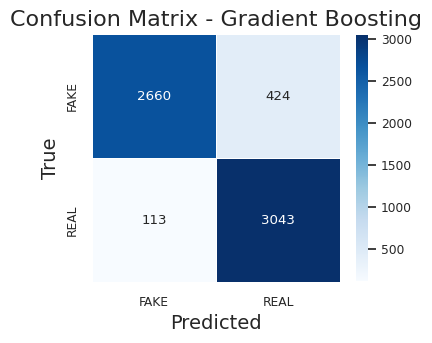

In [ ]:
# Confusion Matrix for Gradient Boosting
cm_gb = confusion_matrix(ytest, y_pred_gb)
plot_confusion_matrix(cm_gb, classes=['FAKE', 'REAL'], model_name='Gradient Boosting')


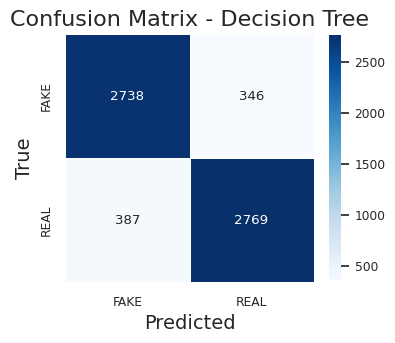

In [ ]:

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(ytest, y_pred_dt)
plot_confusion_matrix(cm_dt, classes=['FAKE', 'REAL'], model_name='Decision Tree')



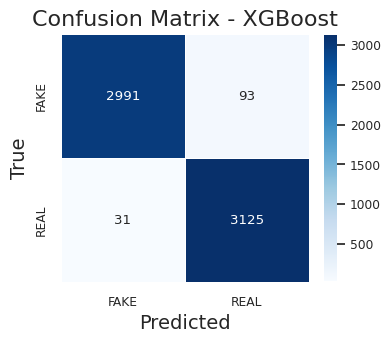

In [ ]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(ytest, y_pred_xgb)
plot_confusion_matrix(cm_xgb, classes=['FAKE', 'REAL'], model_name='XGBoost')



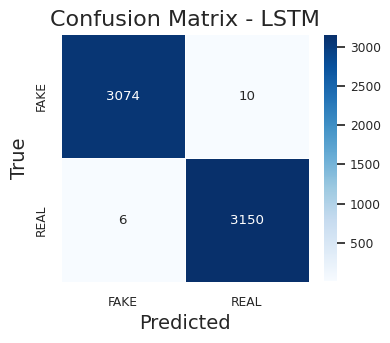

In [ ]:
# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(ytest, predictions)
plot_confusion_matrix(cm_lstm, classes=['FAKE', 'REAL'], model_name='LSTM')



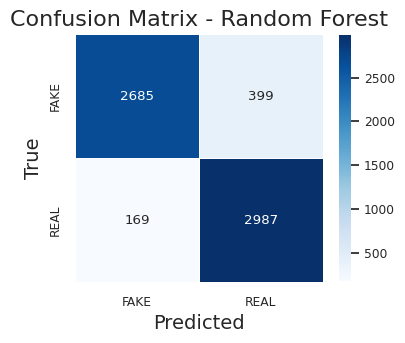

In [ ]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(ytest, y_pred_rf)
plot_confusion_matrix(cm_rf, classes=['FAKE', 'REAL'], model_name='Random Forest')

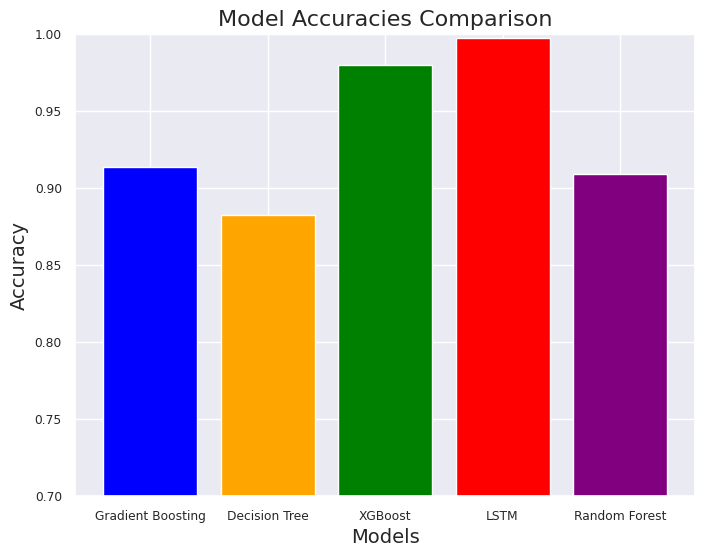

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Model names and corresponding accuracies
model_names = [ 'Gradient Boosting', 'Decision Tree', 'XGBoost', 'LSTM', 'Random Forest']
accuracies = [accuracy_gb, accuracy_dt, accuracy_xgb, accuracy, accuracy_rf]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracies Comparison', fontsize=16)
plt.ylim(0.70, 1.0)  # Adjust the y-axis limits if needed
plt.show()
